

# Import các thư viện cần thiết


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Deep Learning Models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Evaluation
from sklearn.metrics import classification_report, accuracy_score

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Đọc tập dữ liệu

In [ ]:
# Load the dataset
df = pd.read_csv('salesforce_customers.csv')

print("=== First 5 Rows of Data ===")
print(df.head())
print("\n=== Data Info ===")
df.info()
print("\n=== Target Variable Distribution ===")
print(df['CustomerStatus'].value_counts())

=== First 5 Rows of Data ===
            ContactId FirstName   LastName  \
0  003F5MOpooFx0klKq0     Jenna      Lynch   
1  0032a05fkRkDmLPEbZ      Lisa    Burnett   
2  003Byziav0h2Tjksua   Michael  Carpenter   
3  0039nkg4q5RLqzj6HV   Jessica      Scott   
4  003KMHwLzhU1Myfshz     Jason   Anderson   

                                Email               Phone  \
0       jenna.lynch@normanandsons.com       (607)533-1347   
1             lisa.burnett@vaughn.com  (935)627-9947x1870   
2  michael.carpenter@jordan-smith.com       (577)945-5105   
3             jessica.scott@lopez.com    001-635-459-6055   
4   jason.anderson@gardner-miller.com          8816740907   

                 AccountName    Industry  AnnualRevenue  NumberOfEmployees  \
0            Norman and Sons  Technology       97128887               7828   
1  Vaughn, Reynolds and Pace  Healthcare       18064886                400   
2               Jordan-Smith  Healthcare        2004488                184   
3  Lopez, Goodm

# Các bước tiền xử lý dữ liệu

## Tạo các cột thời gian liên quan

In [ ]:
# Convert date columns to datetime objects
df['CreatedDate'] = pd.to_datetime(df['CreatedDate'])
df['LastActivityDate'] = pd.to_datetime(df['LastActivityDate'])

# Create new features
current_date = datetime.now()
df['CustomerTenure'] = (current_date - df['CreatedDate']).dt.days
df['DaysSinceLastActivity'] = (current_date - df['LastActivityDate']).dt.days

# Drop original date columns and identifiers that are not useful for training
df = df.drop(['ContactId', 'FirstName', 'LastName', 'Email', 'Phone', 'AccountName', 'CreatedDate', 'LastActivityDate'], axis=1)

print("\n=== Data After Feature Engineering ===")
print(df.head())


=== Data After Feature Engineering ===
     Industry  AnnualRevenue  NumberOfEmployees        LeadSource  TotalSpend  \
0  Technology       97128887               7828     Phone Inquiry   574275.85   
1  Healthcare       18064886                400               Web  1298180.81   
2  Healthcare        2004488                184  Partner Referral   148237.11   
3  Healthcare       17257589                205    Purchased List  1170305.85   
4  Consulting        3580248                378  Partner Referral   282992.84   

   SupportCasesOpened  MarketingEngagementScore CustomerStatus  \
0                  27                        91        Churned   
1                   5                        86       Prospect   
2                  19                       100         Active   
3                  15                        75       Prospect   
4                   1                        41       Prospect   

   CustomerTenure  DaysSinceLastActivity  
0             943                

## Xử lý giá trị thiếu, giá trị ngoại lai

Tổng số giá trị thiếu trong mỗi cột:
ContactId                   0
FirstName                   0
LastName                    0
Email                       0
Phone                       0
AccountName                 0
Industry                    0
AnnualRevenue               0
NumberOfEmployees           0
LeadSource                  0
CreatedDate                 0
LastActivityDate            0
TotalSpend                  0
SupportCasesOpened          0
MarketingEngagementScore    0
CustomerStatus              0
dtype: int64


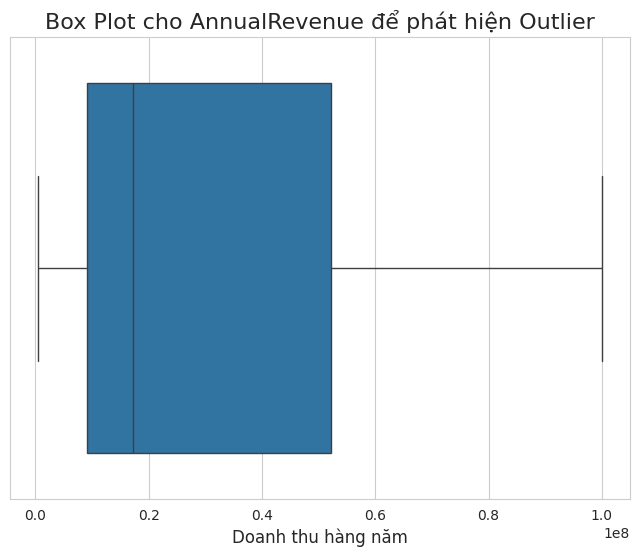

Phân tích: Có các giá trị ngoại lai, nhưng chúng có thể là các khách hàng lớn, có giá trị. Trong bài toán này, chúng ta sẽ giữ lại chúng.

Đã chuyển đổi kiểu dữ liệu của các cột ngày tháng:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ContactId                 5000 non-null   object        
 1   FirstName                 5000 non-null   object        
 2   LastName                  5000 non-null   object        
 3   Email                     5000 non-null   object        
 4   Phone                     5000 non-null   object        
 5   AccountName               5000 non-null   object        
 6   Industry                  5000 non-null   object        
 7   AnnualRevenue             5000 non-null   int64         
 8   NumberOfEmployees         5000 non-null   int64         
 9   LeadSource      

In [ ]:
# --- Xử lý giá trị thiếu (Missing Values) ---
print(f"Tổng số giá trị thiếu trong mỗi cột:\n{df.isnull().sum()}")
# Kết luận: Dữ liệu tổng hợp này không có giá trị thiếu.

# --- Xử lý dữ liệu ngoại lai (Outliers) ---
# Trực quan hóa outlier trong cột 'AnnualRevenue' bằng box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['AnnualRevenue'])
plt.title('Box Plot cho AnnualRevenue để phát hiện Outlier', fontsize=16)
plt.xlabel('Doanh thu hàng năm', fontsize=12)
plt.show()
print("Phân tích: Có các giá trị ngoại lai, nhưng chúng có thể là các khách hàng lớn, có giá trị. Trong bài toán này, chúng ta sẽ giữ lại chúng.")

# --- Xử lý cột ngày tháng (Date Feature) ---
# Chuyển đổi từ kiểu 'object' sang 'datetime'
df['CreatedDate'] = pd.to_datetime(df['CreatedDate'])
df['LastActivityDate'] = pd.to_datetime(df['LastActivityDate'])
print("\nĐã chuyển đổi kiểu dữ liệu của các cột ngày tháng:")
df.info()

In [ ]:
# Tạo một bản sao để hiển thị các bước tiền xử lý
df_eda = df.copy()

# Thiết lập style cho biểu đồ
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100 # Adjust figure resolution

## EDA

=== Bước 1: Kỹ thuật Đặc trưng (Feature Engineering) ===


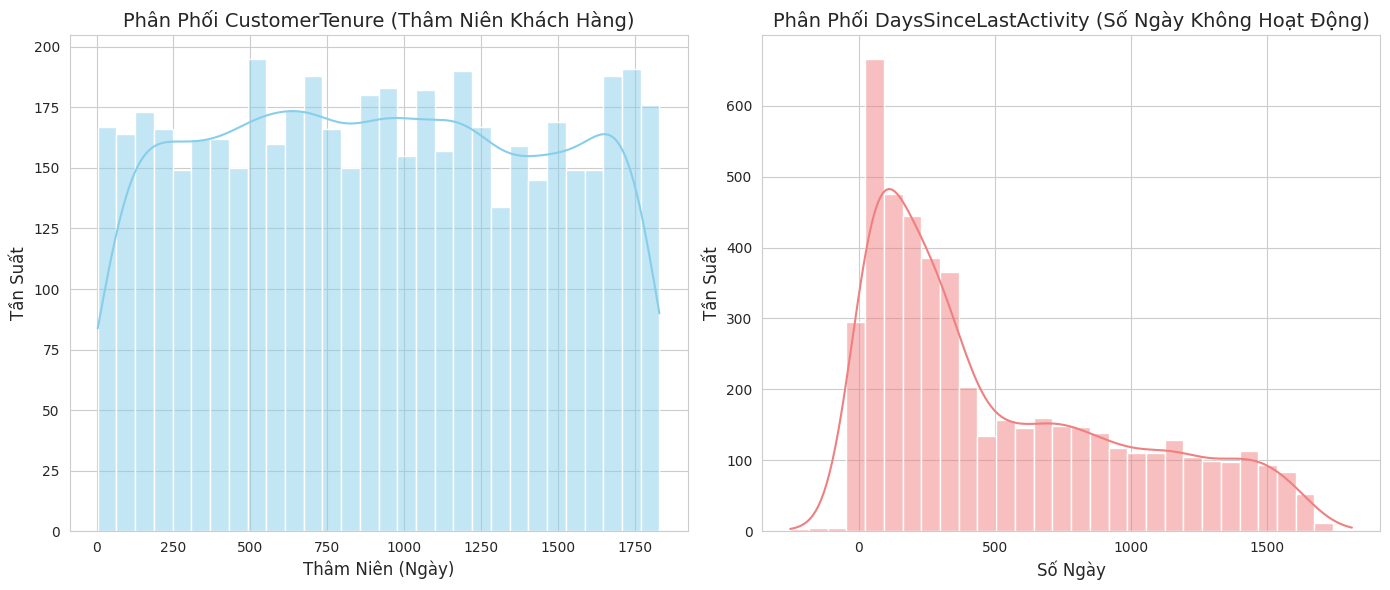

Đã tạo CustomerTenure và DaysSinceLastActivity.
          CreatedDate  CustomerTenure    LastActivityDate  \
0 2023-03-20 18:12:10             943 2023-11-14 18:12:10   
1 2022-11-26 17:02:27            1057 2025-01-20 07:31:25   
2 2021-10-06 21:19:32            1473 2023-09-23 04:11:54   
3 2025-06-08 03:05:53             133 2025-08-12 17:01:41   
4 2022-03-17 05:23:02            1312 2025-09-28 16:52:51   

   DaysSinceLastActivity  
0                    704  
1                    272  
2                    757  
3                     67  
4                     20  
----------------------------------------------------------------------


In [ ]:
print("=== Bước 1: Kỹ thuật Đặc trưng (Feature Engineering) ===")

# Chuyển đổi cột ngày tháng
df_eda['CreatedDate'] = pd.to_datetime(df_eda['CreatedDate'])
df_eda['LastActivityDate'] = pd.to_datetime(df_eda['LastActivityDate'])

# Tạo các đặc trưng mới
current_date = datetime.now()

# --- SỬA LỖI Ở ĐÂY ---
# Thay thế 'current_eda' bằng 'current_date'
df_eda['CustomerTenure'] = (current_date - df_eda['CreatedDate']).dt.days
df_eda['DaysSinceLastActivity'] = (current_date - df_eda['LastActivityDate']).dt.days
# --------------------

# --- Vẽ biểu đồ cho các đặc trưng mới ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_eda['CustomerTenure'], kde=True, bins=30, color='skyblue')
plt.title('Phân Phối CustomerTenure (Thâm Niên Khách Hàng)', fontsize=14)
plt.xlabel('Thâm Niên (Ngày)', fontsize=12)
plt.ylabel('Tần Suất', fontsize=12)

plt.subplot(1, 2, 2)
sns.histplot(df_eda['DaysSinceLastActivity'], kde=True, bins=30, color='lightcoral')
plt.title('Phân Phối DaysSinceLastActivity (Số Ngày Không Hoạt Động)', fontsize=14)
plt.xlabel('Số Ngày', fontsize=12)
plt.ylabel('Tần Suất', fontsize=12)

plt.tight_layout()
plt.show()

print("Đã tạo CustomerTenure và DaysSinceLastActivity.")
print(df_eda[['CreatedDate', 'CustomerTenure', 'LastActivityDate', 'DaysSinceLastActivity']].head())
print("-" * 70)


=== Bước 2: Mã hóa One-Hot cho Dữ liệu Phân loại ===
Dữ liệu phân loại gốc (ví dụ 5 hàng đầu):
                 AccountName    Industry        LeadSource
0            Norman and Sons  Technology     Phone Inquiry
1  Vaughn, Reynolds and Pace  Healthcare               Web
2               Jordan-Smith  Healthcare  Partner Referral
3  Lopez, Goodman and Tanner  Healthcare    Purchased List
4             Gardner-Miller  Consulting  Partner Referral

Dữ liệu 'Industry' sau One-Hot Encoding (ví dụ 5 hàng đầu):
   Industry_Consulting  Industry_Finance  Industry_Healthcare  \
0                  0.0               0.0                  0.0   
1                  0.0               0.0                  1.0   
2                  0.0               0.0                  1.0   
3                  0.0               0.0                  1.0   
4                  1.0               0.0                  0.0   

   Industry_Manufacturing  Industry_Retail  Industry_Technology  
0                     0.0       

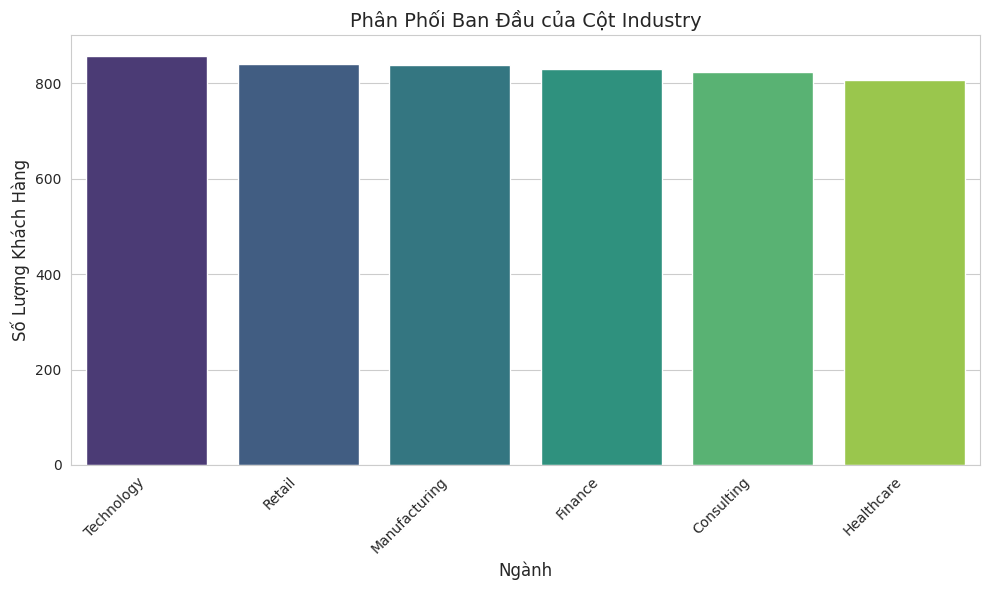

One-Hot Encoding chuyển đổi các cột phân loại thành dạng số, mở rộng số lượng cột.
----------------------------------------------------------------------


In [ ]:
print("\n=== Bước 2: Mã hóa One-Hot cho Dữ liệu Phân loại ===")

# Lấy một vài cột để minh họa
df_categorical_sample = df_eda[['AccountName', 'Industry', 'LeadSource']].head()
print("Dữ liệu phân loại gốc (ví dụ 5 hàng đầu):")
print(df_categorical_sample)

# Áp dụng One-Hot Encoding (chỉ cho mục đích minh họa trực quan)
# Trong pipeline thực tế, OneHotEncoder sẽ xử lý toàn bộ X_train
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
industry_encoded = ohe.fit_transform(df_eda[['Industry']])
industry_df = pd.DataFrame(industry_encoded, columns=ohe.get_feature_names_out(['Industry']))

# Hiển thị phần dữ liệu đã được mã hóa (5 hàng đầu)
print("\nDữ liệu 'Industry' sau One-Hot Encoding (ví dụ 5 hàng đầu):")
print(industry_df.head())

# --- Biểu đồ minh họa One-Hot Encoding ---
plt.figure(figsize=(10, 6))
sns.countplot(x='Industry', data=df_eda, palette='viridis', order=df_eda['Industry'].value_counts().index)
plt.title('Phân Phối Ban Đầu của Cột Industry', fontsize=14)
plt.xlabel('Ngành', fontsize=12)
plt.ylabel('Số Lượng Khách Hàng', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Minh họa cách các cột mới sẽ xuất hiện trong DataFrame
# (không vẽ biểu đồ trực tiếp cho từng cột 0/1, mà chỉ hiển thị dữ liệu)

print("One-Hot Encoding chuyển đổi các cột phân loại thành dạng số, mở rộng số lượng cột.")
print("-" * 70)


=== Bước 3: Chuẩn hóa Dữ liệu Số (Standard Scaling) ===


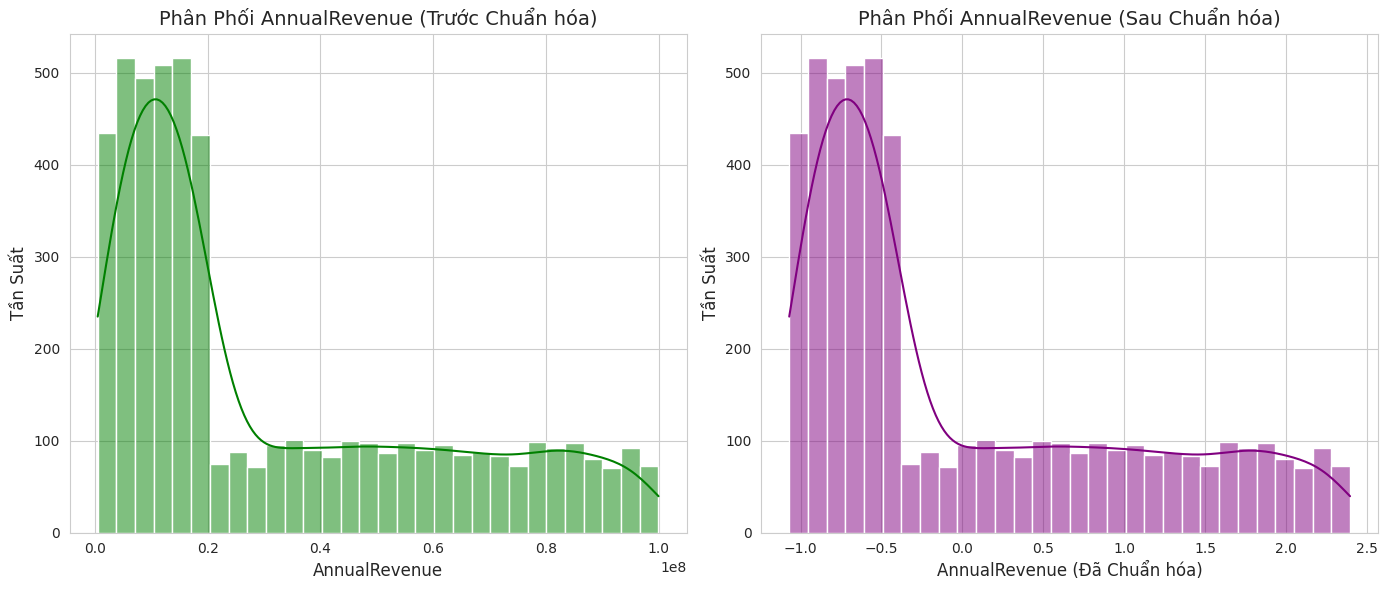

Giá trị trung bình của AnnualRevenue gốc: 31217069.11
Độ lệch chuẩn của AnnualRevenue gốc: 28701061.37
Giá trị trung bình của AnnualRevenue sau chuẩn hóa: 0.00
Độ lệch chuẩn của AnnualRevenue sau chuẩn hóa: 1.00
Sau chuẩn hóa, dữ liệu có trung bình gần 0 và độ lệch chuẩn gần 1.
----------------------------------------------------------------------


In [ ]:
print("\n=== Bước 3: Chuẩn hóa Dữ liệu Số (Standard Scaling) ===")

from sklearn.preprocessing import MinMaxScaler

# Chọn một cột số để minh họa
feature_to_scale = 'AnnualRevenue'

# Lấy dữ liệu gốc
original_data = df_eda[[feature_to_scale]].values

# Áp dụng StandardScaler (chỉ cho mục đích minh họa trực quan)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(original_data)

# Chuyển đổi thành DataFrame để dễ dàng vẽ biểu đồ
scaled_df = pd.DataFrame(scaled_data, columns=[feature_to_scale + '_Scaled'])

# --- Biểu đồ so sánh trước và sau chuẩn hóa ---
plt.figure(figsize=(14, 6))

# Trước chuẩn hóa
plt.subplot(1, 2, 1)
sns.histplot(df_eda[feature_to_scale], kde=True, bins=30, color='green')
plt.title(f'Phân Phối {feature_to_scale} (Trước Chuẩn hóa)', fontsize=14)
plt.xlabel(feature_to_scale, fontsize=12)
plt.ylabel('Tần Suất', fontsize=12)

# Sau chuẩn hóa
plt.subplot(1, 2, 2)
sns.histplot(scaled_df[feature_to_scale + '_Scaled'], kde=True, bins=30, color='purple')
plt.title(f'Phân Phối {feature_to_scale} (Sau Chuẩn hóa)', fontsize=14)
plt.xlabel(f'{feature_to_scale} (Đã Chuẩn hóa)', fontsize=12)
plt.ylabel('Tần Suất', fontsize=12)

plt.tight_layout()
plt.show()

print(f"Giá trị trung bình của {feature_to_scale} gốc: {df_eda[feature_to_scale].mean():.2f}")
print(f"Độ lệch chuẩn của {feature_to_scale} gốc: {df_eda[feature_to_scale].std():.2f}")
print(f"Giá trị trung bình của {feature_to_scale} sau chuẩn hóa: {scaled_df[feature_to_scale + '_Scaled'].mean():.2f}")
print(f"Độ lệch chuẩn của {feature_to_scale} sau chuẩn hóa: {scaled_df[feature_to_scale + '_Scaled'].std():.2f}")
print("Sau chuẩn hóa, dữ liệu có trung bình gần 0 và độ lệch chuẩn gần 1.")
print("-" * 70)

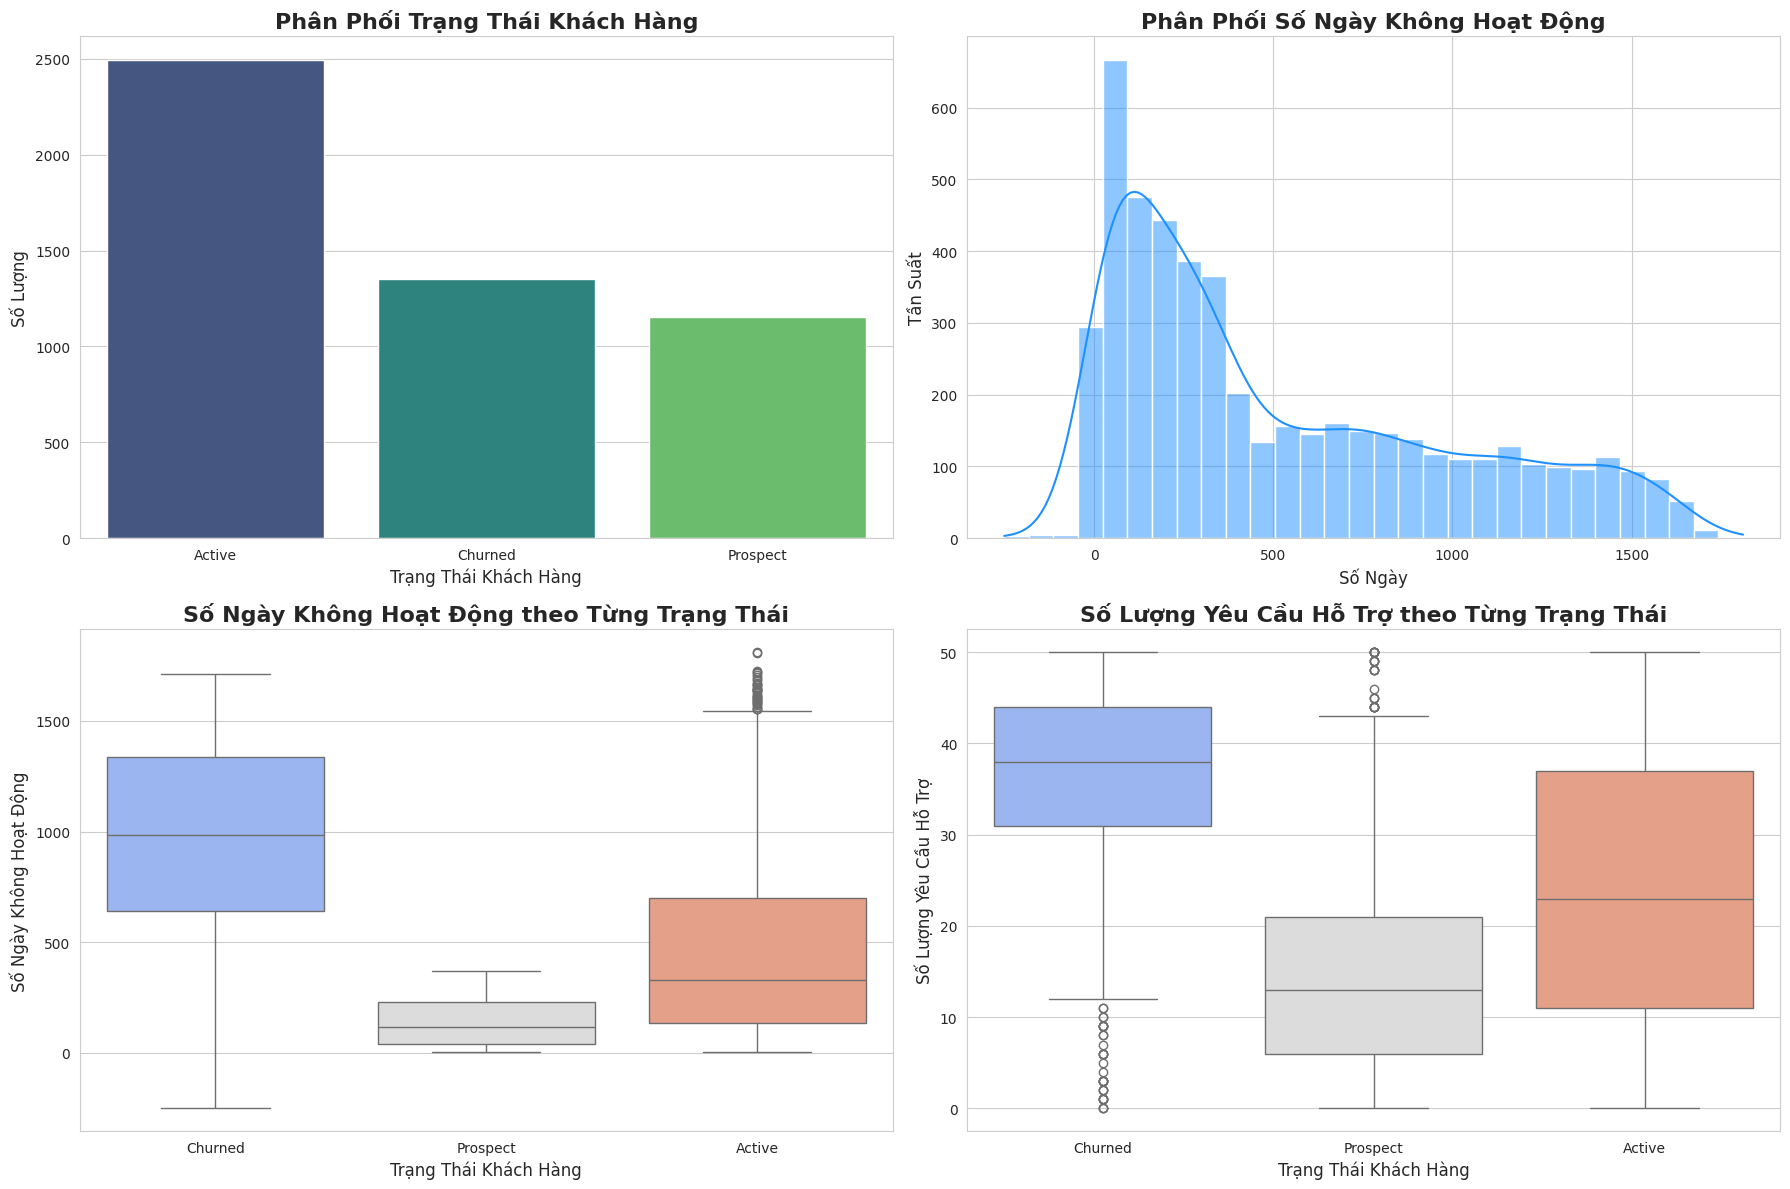

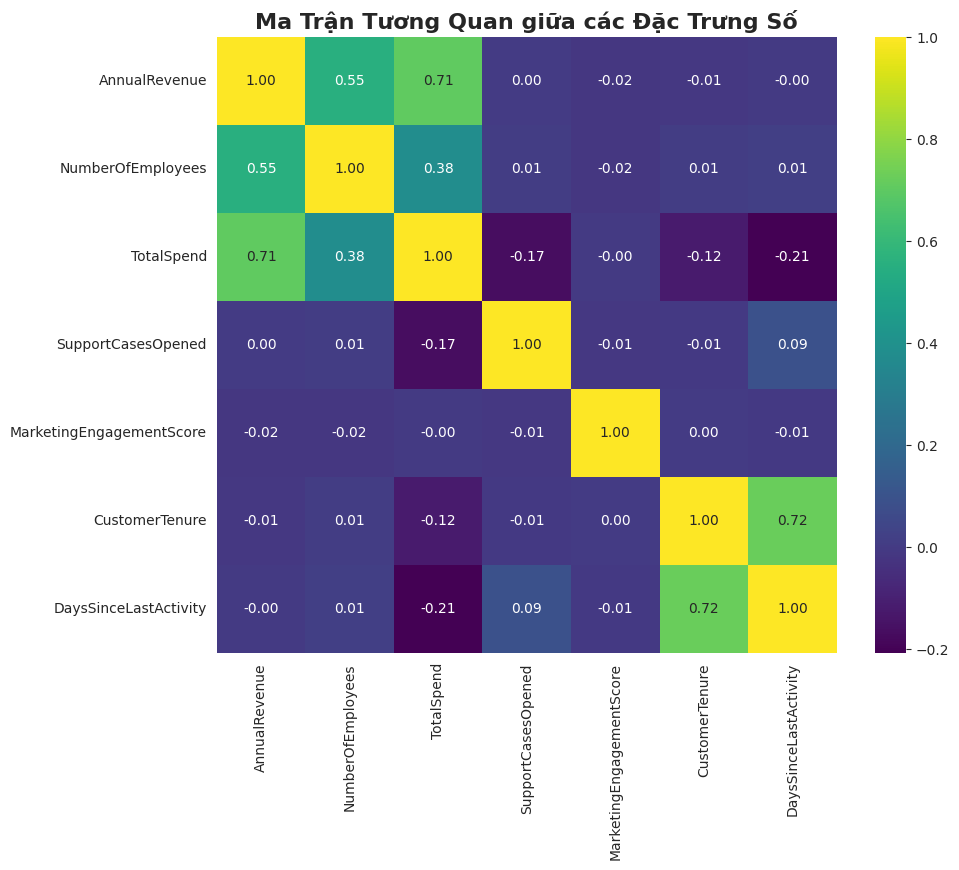

In [ ]:

# --- Plot 1: Phân phối của Biến Mục Tiêu (CustomerStatus) ---
plt.subplot(2, 2, 1)
sns.countplot(x='CustomerStatus', data=df, palette='viridis', order=df['CustomerStatus'].value_counts().index)
plt.title('Phân Phối Trạng Thái Khách Hàng', fontsize=16, fontweight='bold')
plt.xlabel('Trạng Thái Khách Hàng', fontsize=12)
plt.ylabel('Số Lượng', fontsize=12)

# --- Plot 2: Phân phối của 'DaysSinceLastActivity' ---
plt.subplot(2, 2, 2)
sns.histplot(df['DaysSinceLastActivity'], kde=True, bins=30, color='dodgerblue')
plt.title('Phân Phối Số Ngày Không Hoạt Động', fontsize=16, fontweight='bold')
plt.xlabel('Số Ngày', fontsize=12)
plt.ylabel('Tần Suất', fontsize=12)

# --- Plot 3: Box Plot so sánh 'DaysSinceLastActivity' theo CustomerStatus ---
plt.subplot(2, 2, 3)
sns.boxplot(x='CustomerStatus', y='DaysSinceLastActivity', data=df, palette='coolwarm')
plt.title('Số Ngày Không Hoạt Động theo Từng Trạng Thái', fontsize=16, fontweight='bold')
plt.xlabel('Trạng Thái Khách Hàng', fontsize=12)
plt.ylabel('Số Ngày Không Hoạt Động', fontsize=12)

# --- Plot 4: Box Plot so sánh 'SupportCasesOpened' theo CustomerStatus ---
plt.subplot(2, 2, 4)
sns.boxplot(x='CustomerStatus', y='SupportCasesOpened', data=df, palette='coolwarm')
plt.title('Số Lượng Yêu Cầu Hỗ Trợ theo Từng Trạng Thái', fontsize=16, fontweight='bold')
plt.xlabel('Trạng Thái Khách Hàng', fontsize=12)
plt.ylabel('Số Lượng Yêu Cầu Hỗ Trợ', fontsize=12)

plt.tight_layout()
plt.show()

# --- Plot 5: Ma trận Tương quan (Correlation Matrix) ---
plt.figure(figsize=(10, 8))
# Chọn các cột số để tính tương quan
numerical_cols = df.select_dtypes(include=['number']).columns
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f')
plt.title('Ma Trận Tương Quan giữa các Đặc Trưng Số', fontsize=16, fontweight='bold')
plt.show()

# Huấn luyện các mô hình học máy, học sâu

## Huấn luyện từng mô hình riêng lẻ


In [ ]:
# Create the full pipeline with the model
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42))])

# Train the model
print("\n--- Training Logistic Regression ---")
lr_pipeline.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_lr = lr_pipeline.predict(X_test)
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))


--- Training Logistic Regression ---
Logistic Regression Results:
Accuracy: 0.8470
              precision    recall  f1-score   support

      Active       0.85      0.85      0.85       498
     Churned       0.91      0.94      0.92       271
    Prospect       0.75      0.74      0.75       231

    accuracy                           0.85      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.85      0.85      0.85      1000



In [ ]:
# Create the full pipeline with the model
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

# Train the model
print("\n--- Training Random Forest ---")
rf_pipeline.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_rf = rf_pipeline.predict(X_test)
print("Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))


--- Training Random Forest ---
Random Forest Results:
Accuracy: 0.9710
              precision    recall  f1-score   support

      Active       0.95      1.00      0.97       498
     Churned       0.99      0.91      0.95       271
    Prospect       1.00      0.99      0.99       231

    accuracy                           0.97      1000
   macro avg       0.98      0.96      0.97      1000
weighted avg       0.97      0.97      0.97      1000



In [ ]:
# Apply the preprocessing steps to our data first
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# For deep learning, the target needs to be one-hot encoded
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Build the model
basic_nn = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax') # 3 output neurons for 3 classes
])

basic_nn.summary()

basic_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
print("\n--- Training Basic Neural Network ---")
basic_nn.fit(X_train_processed, y_train_cat, epochs=20, batch_size=32, verbose=0, validation_split=0.1)

# Predictions and Evaluation
y_pred_nn_prob = basic_nn.predict(X_test_processed)
y_pred_nn = np.argmax(y_pred_nn_prob, axis=1) # Convert probabilities to class labels
print("Basic Neural Network Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")
print(classification_report(y_test, y_pred_nn, target_names=label_encoder.classes_))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,187 (4.64 KB)

 Trainable params: 1,187 (4.64 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Basic Neural Network ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Basic Neural Network Results:
Accuracy: 0.8850
              precision    recall  f1-score   support

      Active       0.88      0.89      0.89       498
     Churned       0.97      0.92      0.94       271
    Prospect       0.80      0.84      0.82       231

    accuracy                           0.89      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.89      0.89      1000



In [ ]:
# Build the model
adv_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dropout(0.3), # Dropout layer for regularization
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

adv_nn.summary()

adv_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
print("\n--- Training Advanced Neural Network ---")
adv_nn.fit(X_train_processed, y_train_cat, epochs=20, batch_size=32, verbose=0, validation_split=0.1)

# Predictions and Evaluation
y_pred_adv_nn_prob = adv_nn.predict(X_test_processed)
y_pred_adv_nn = np.argmax(y_pred_adv_nn_prob, axis=1)
print("Advanced Neural Network Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adv_nn):.4f}")
print(classification_report(y_test, y_pred_adv_nn, target_names=label_encoder.classes_))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,395 (13.26 KB)

 Trainable params: 3,395 (13.26 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Advanced Neural Network ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Advanced Neural Network Results:
Accuracy: 0.8940
              precision    recall  f1-score   support

      Active       0.88      0.92      0.90       498
     Churned       0.97      0.91      0.94       271
    Prospect       0.85      0.83      0.84       231

    accuracy                           0.89      1000
   macro avg       0.90      0.88      0.89      1000
weighted avg       0.90      0.89      0.89      1000



## Huấn luyện các mô hình cùng lúc để lấy chỉ số đánh giá chung

In [ ]:
# Dictionary to store results
results = {}

# --- 1. Logistic Regression ---
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(random_state=42))])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
y_prob_lr = lr_pipeline.predict_proba(X_test)

results['Logistic Regression'] = {
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr, average='weighted'),
    "Recall": recall_score(y_test, y_pred_lr, average='weighted'),
    "F1-Score": f1_score(y_test, y_pred_lr, average='weighted'),
    "AUC (OvR)": roc_auc_score(y_test, y_prob_lr, multi_class='ovr')
}
print("Logistic Regression Evaluated.")

# --- 2. Random Forest ---
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)

results['Random Forest'] = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf, average='weighted'),
    "Recall": recall_score(y_test, y_pred_rf, average='weighted'),
    "F1-Score": f1_score(y_test, y_pred_rf, average='weighted'),
    "AUC (OvR)": roc_auc_score(y_test, y_prob_rf, multi_class='ovr')
}
print("Random Forest Evaluated.")


# --- Preprocessing for Deep Learning ---
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
y_train_cat = to_categorical(y_train, num_classes=3)

# --- 3. Basic Neural Network ---
basic_nn = Sequential([Dense(32, activation='relu', input_shape=(X_train_processed.shape[1],)), Dense(16, activation='relu'), Dense(3, activation='softmax')])
basic_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
basic_nn.fit(X_train_processed, y_train_cat, epochs=20, batch_size=32, verbose=0)
y_prob_nn = basic_nn.predict(X_test_processed)
y_pred_nn = np.argmax(y_prob_nn, axis=1)

results['Basic NN'] = {
    "Accuracy": accuracy_score(y_test, y_pred_nn),
    "Precision": precision_score(y_test, y_pred_nn, average='weighted'),
    "Recall": recall_score(y_test, y_pred_nn, average='weighted'),
    "F1-Score": f1_score(y_test, y_pred_nn, average='weighted'),
    "AUC (OvR)": roc_auc_score(y_test, y_prob_nn, multi_class='ovr')
}
print("Basic NN Evaluated.")

# --- 4. Advanced Neural Network ---
adv_nn = Sequential([Dense(64, activation='relu', input_shape=(X_train_processed.shape[1],)), Dropout(0.3), Dense(32, activation='relu'), Dropout(0.2), Dense(3, activation='softmax')])
adv_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
adv_nn.fit(X_train_processed, y_train_cat, epochs=20, batch_size=32, verbose=0)
y_prob_adv_nn = adv_nn.predict(X_test_processed)
y_pred_adv_nn = np.argmax(y_prob_adv_nn, axis=1)

results['Advanced NN'] = {
    "Accuracy": accuracy_score(y_test, y_pred_adv_nn),
    "Precision": precision_score(y_test, y_pred_adv_nn, average='weighted'),
    "Recall": recall_score(y_test, y_pred_adv_nn, average='weighted'),
    "F1-Score": f1_score(y_test, y_pred_adv_nn, average='weighted'),
    "AUC (OvR)": roc_auc_score(y_test, y_prob_adv_nn, multi_class='ovr')
}
print("Advanced NN Evaluated.")

# --- Display Results in a DataFrame ---
results_df = pd.DataFrame(results).T
print("\n=== Comprehensive Model Comparison ===")
print(results_df)

Logistic Regression Evaluated.
Random Forest Evaluated.
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Basic NN Evaluated.
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Advanced NN Evaluated.

=== Comprehensive Model Comparison ===
                     Accuracy  Precision  Recall  F1-Score  AUC (OvR)
Logistic Regression     0.847   0.846250   0.847  0.846554   0.956282
Random Forest           0.971   0.972114   0.971  0.970795   0.996852
Basic NN                0.890   0.890908   0.890  0.890334   0.972375
Advanced NN             0.895   0.895962   0.895  0.895335   0.973835


# Phân tích kết quả

In [ ]:
print("\n" + "="*25 + " PHÂN TÍCH SÂU " + "="*25)

print("\n--- Báo cáo chi tiết cho Random Forest (Mô hình tốt nhất) ---")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

print("\n--- Báo cáo chi tiết cho Logistic Regression (Mô hình cơ bản) ---")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))


========================= PHÂN TÍCH SÂU =========================

--- Báo cáo chi tiết cho Random Forest (Mô hình tốt nhất) ---
              precision    recall  f1-score   support

      Active       0.95      1.00      0.97       498
     Churned       0.99      0.91      0.95       271
    Prospect       1.00      0.99      0.99       231

    accuracy                           0.97      1000
   macro avg       0.98      0.96      0.97      1000
weighted avg       0.97      0.97      0.97      1000


--- Báo cáo chi tiết cho Logistic Regression (Mô hình cơ bản) ---
              precision    recall  f1-score   support

      Active       0.85      0.85      0.85       498
     Churned       0.91      0.94      0.92       271
    Prospect       0.75      0.74      0.75       231

    accuracy                           0.85      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.85      0.85      0.85      1000



In [ ]:
# Tạo một DataFrame để dễ dàng so sánh dự đoán và thực tế
error_analysis_df = X_test.copy()
error_analysis_df['TrueStatus'] = label_encoder.inverse_transform(y_test)
error_analysis_df['PredictedStatus_RF'] = label_encoder.inverse_transform(y_pred_rf)

# Tìm những trường hợp dự đoán sai của Random Forest
misclassified = error_analysis_df[error_analysis_df['TrueStatus'] != error_analysis_df['PredictedStatus_RF']]

print("\n" + "="*25 + " PHÂN TÍCH LỖI " + "="*25)
print(f"\nRandom Forest đã dự đoán sai {len(misclassified)} trường hợp.")
print("5 trường hợp dự đoán sai tiêu biểu:")
print(misclassified.head())


========================= PHÂN TÍCH LỖI =========================

Random Forest đã dự đoán sai 29 trường hợp.
5 trường hợp dự đoán sai tiêu biểu:
           Industry  AnnualRevenue  NumberOfEmployees        LeadSource  \
3506     Consulting        9586443                252    Purchased List   
3252     Consulting         984533                126  Partner Referral   
3800     Consulting        3227882                342  Partner Referral   
1683  Manufacturing       47771868               3819     Phone Inquiry   
4263     Healthcare       13398250                162  Partner Referral   

      TotalSpend  SupportCasesOpened  MarketingEngagementScore  \
3506   126109.47                  30                        56   
3252    49456.97                  17                        16   
3800    41128.14                  43                        48   
1683   328393.85                  25                        60   
4263   175500.32                  18                        80   

    

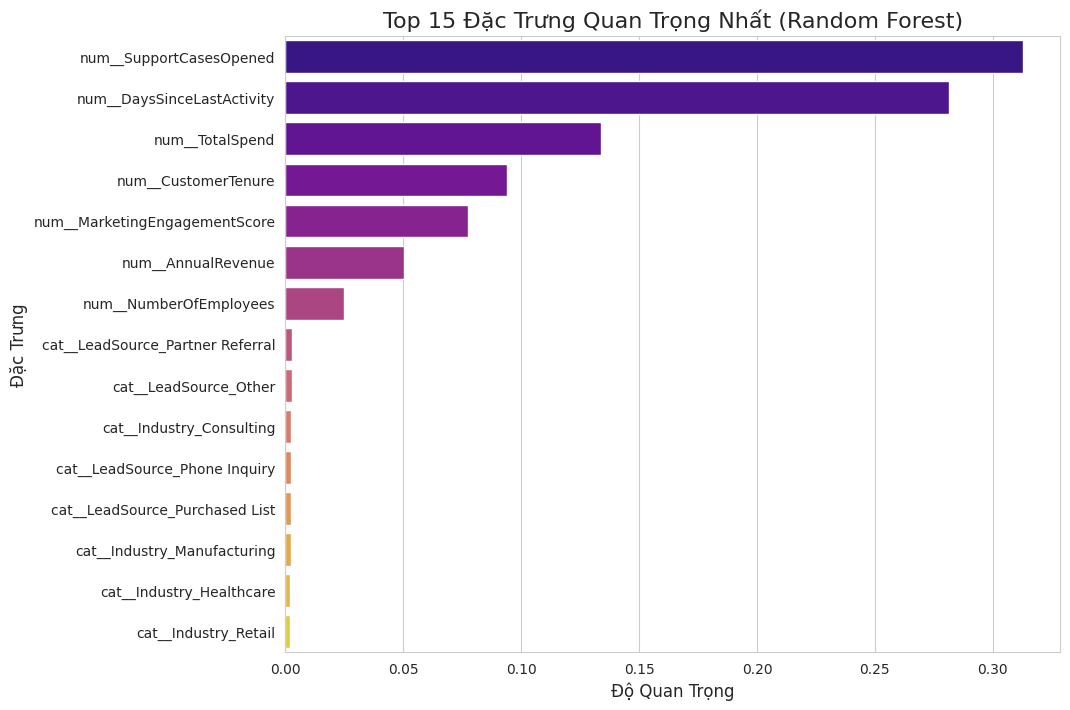

In [ ]:
# Lấy mô hình Random Forest từ pipeline
rf_model = rf_pipeline.named_steps['classifier']

# Lấy tên các đặc trưng sau khi đã được tiền xử lý
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Lấy độ quan trọng của các đặc trưng
importances = rf_model.feature_importances_

# Tạo DataFrame để trực quan hóa
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='plasma')
plt.title('Top 15 Đặc Trưng Quan Trọng Nhất (Random Forest)', fontsize=16)
plt.xlabel('Độ Quan Trọng', fontsize=12)
plt.ylabel('Đặc Trưng', fontsize=12)
plt.show()

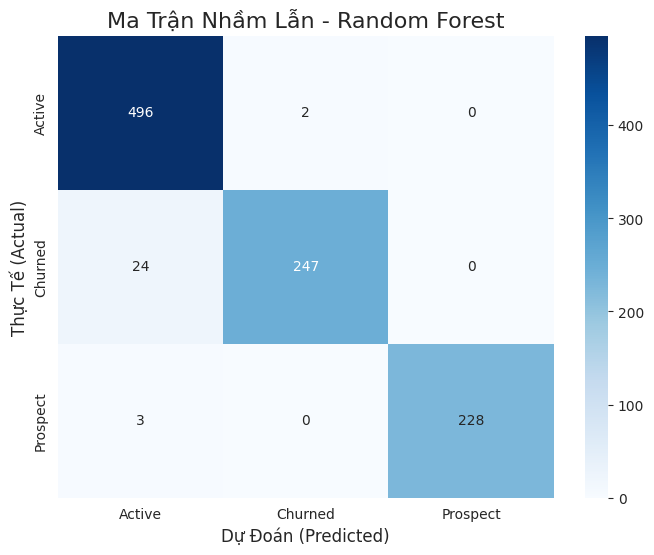

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Sử dụng mô hình tốt nhất (ví dụ: Random Forest)
y_pred_best = y_pred_rf # Lấy từ kết quả của Random Forest
class_names = label_encoder.classes_

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred_best)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Ma Trận Nhầm Lẫn - Random Forest', fontsize=16)
plt.ylabel('Thực Tế (Actual)', fontsize=12)
plt.xlabel('Dự Đoán (Predicted)', fontsize=12)
plt.show()

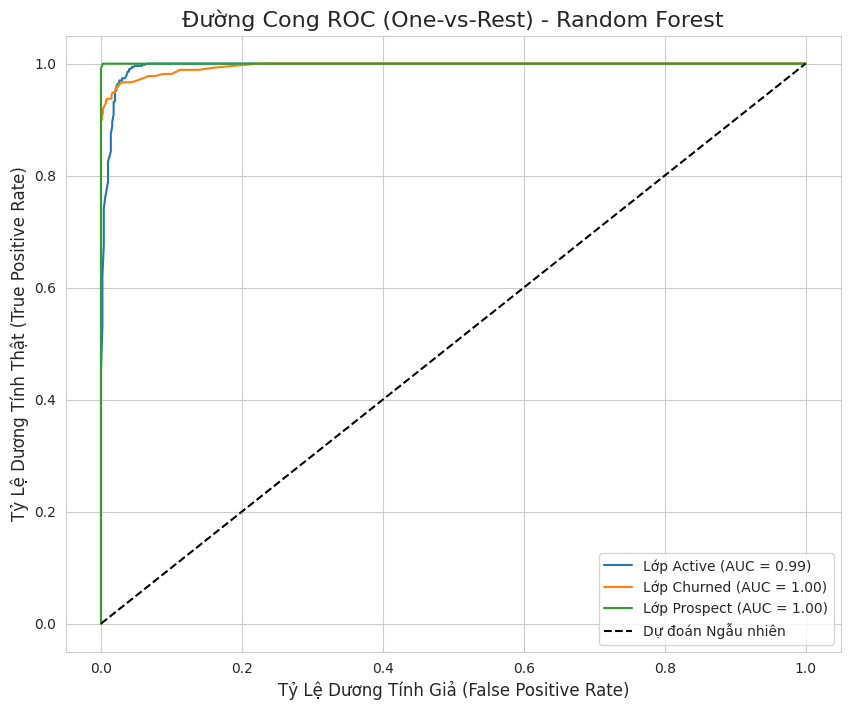

In [ ]:
# Binarize (Nhị phân hóa) y_test cho ROC đa lớp
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Lấy xác suất dự đoán của mô hình tốt nhất
y_prob_best = y_prob_rf # Xác suất từ Random Forest

plt.figure(figsize=(10, 8))

# Tính toán và vẽ ROC cho từng lớp
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_best[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Lớp {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Dự đoán Ngẫu nhiên')
plt.xlabel('Tỷ Lệ Dương Tính Giả (False Positive Rate)', fontsize=12)
plt.ylabel('Tỷ Lệ Dương Tính Thật (True Positive Rate)', fontsize=12)
plt.title('Đường Cong ROC (One-vs-Rest) - Random Forest', fontsize=16)
plt.legend()
plt.show()

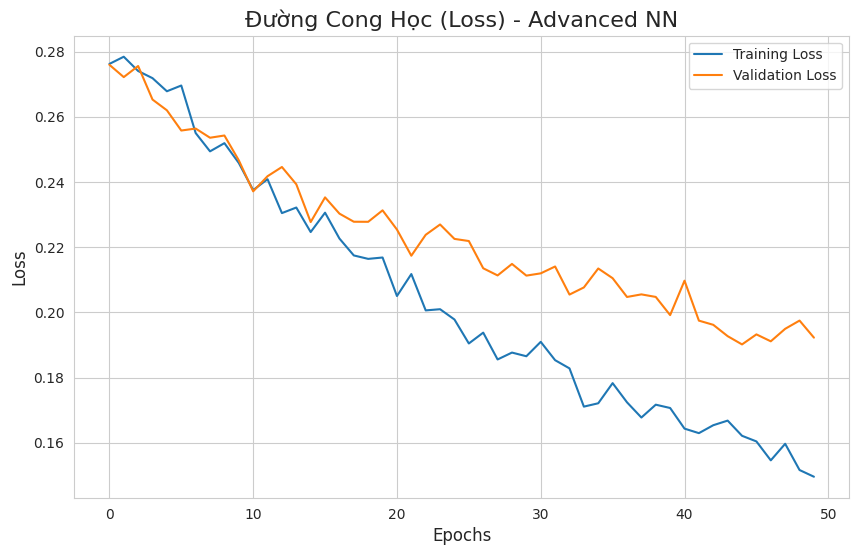

In [ ]:
# --- 4. Advanced Neural Network (Cập nhật) ---
# Thêm validation_data để theo dõi
history = adv_nn.fit(
    X_train_processed,
    y_train_cat,
    epochs=50,  # Tăng số epochs để thấy rõ xu hướng
    batch_size=32,
    verbose=0,
    validation_data=(X_test_processed, to_categorical(y_test, num_classes=3)) # Thêm dòng này
)

# --- Vẽ biểu đồ Learning Curves ---
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(10, 6))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Đường Cong Học (Loss) - Advanced NN', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.show()